### Implementation details of long short-term memory (LSTM)
1. Initialization of LSTM layers

    The LSTM's layers' weights are initialized with std=1 and biases initialized with 0.

2. Initialize the LSTM states to be zeros

    The hidden and cell states of LSTM are initialized with zeros.

3. Reset LSTM states at the end of the episode

4. Prepare sequential rollouts in mini-batches

    In the LSTM setting, the ordering of the training data matter. The mini-batches fetch the sequential training data from sub-environments.

5. Reconstruct LSTM states during training

    The algorithm saves a copy of the LSTM states initial_lstm_state before rollouts. During training, the agent then sequentially reconstruct the LSTM states based on the initial_lstm_state. This process ensures that we reconstructed the probability distributions used in rollouts.



In [ ]:
!pip install --upgrade gym[atari]
!pip install stable_baselines3
!pip install atari-py==0.2.5

In [ ]:
import argparse
import random
import warnings
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from sklearn.model_selection import ShuffleSplit

from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)

In [ ]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer

In [ ]:
class PPOAgent(nn.Module):
    def __init__(self, action_space):
        super(PPOAgent, self).__init__()

        self.network = nn.Sequential(
            layer_init(nn.Conv2d(1, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64*7*7, 512)),
            nn.ReLU(),
        )

        # Initialization of LSTM layers
        self.lstm = nn.LSTM(512, 128)

        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param, 1.0)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)

        self.actor = layer_init(nn.Linear(128, action_space), std=0.01)
        self.critic = layer_init(nn.Linear(128, 1), std=1.0)


    def get_states(self, x, lstm_states, dones):
        hidden = self.network(x / 255.0)

        # Reshape for LSTM input
        num_envs = lstm_states[0].shape[1]
        hidden = hidden.reshape((-1, num_envs, self.lstm.input_size))

        updated_hidden_states = []
        updated_lstm_states = []
        for input_t, done_t in zip(hidden, dones):
            # Reshape input and adjust the states based on termination flags
            input_t = input_t.unsqueeze(0)
            h0 = (1.0 - done_t).view(1, -1, 1) * lstm_states[0]
            c0 = (1.0 - done_t).view(1, -1, 1) * lstm_states[1]

            # Update LSTM states
            h_t, new_lstm_state = self.lstm(input_t, (h0, c0))
            updated_hidden_states.append(h_t)
            updated_lstm_states.append(new_lstm_state)

        lstm_states = updated_lstm_states[-1]
        hidden_states = torch.cat(updated_hidden_states).flatten(0, 1)
        return hidden_states, lstm_states

    def get_value(self, x, lstm_states, dones):
        hidden, _ = self.get_states(x, lstm_states, dones)
        value = self.critic(hidden)
        return value

    def get_action_and_value(self, x, lstm_states, dones, action=None):
        hidden, lstm_states = self.get_states(x, lstm_states, dones)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits) # soft-max distribution

        if action is None:
            action = probs.sample()

        log_prob = probs.log_prob(action)
        entropy = probs.entropy()
        value = self.critic(hidden)

        return action, log_prob, entropy, value, lstm_states

In [ ]:
class PPO:
    def __init__(self, state_shape, action_shape, action_n, config):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.config = config
        self.agent = PPOAgent(action_n).to(config.device)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=config.learning_rate, eps=1e-5)


    def select_action(self, state, lstm_states, dones):
        with torch.no_grad():
            state = torch.Tensor(state).to(self.config.device)
            dones = torch.Tensor(dones).to(self.config.device)
            action, logprob, _, value, lstm_states = self.agent.get_action_and_value(state, lstm_states, dones)
        return action, logprob, value.flatten(), lstm_states


    def get_value(self, state, lstm_states, dones):
        with torch.no_grad():
            state = torch.Tensor(state).to(self.config.device)
            dones = torch.Tensor(dones).to(self.config.device)
            value = self.agent.get_value(state, lstm_states, dones)
        return value.reshape(1, -1)


    def compute_loss(self, trajectory):
        states, actions, returns, dones, values, logprobs, advantages, lstm_states = trajectory

        # Advantages normalization
        if self.config.norm_adv:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Predictions
        _, logprobs_pred, entropy_pred, values_pred, _ = self.agent.get_action_and_value(states, lstm_states, dones, actions)

        log_ratio = logprobs_pred - logprobs
        ratio = log_ratio.exp()

        if (log_ratio.abs() < 1e-6).all().item():
            print("New and old policies are the same: ratio = 1.0")

        with torch.no_grad():
            approx_kl = ((ratio - 1) - log_ratio).mean()
            clip_frac = [((ratio - 1.0).abs() > self.config.clip_coef).float().mean().item()]

        if approx_kl > 0.02:
             print(f"The policy is changing too quickly: approx_kl = {approx_kl}, which is more than 0.02")

        # Policy loss
        pg_loss_unclipped = -advantages * ratio
        pg_loss_clipped = -advantages * torch.clamp(ratio, 1 - self.config.clip_coef, 1 + self.config.clip_coef)
        pg_loss = torch.max(pg_loss_unclipped, pg_loss_clipped).mean()

        # Value loss
        values_pred = values_pred.view(-1)

        v_loss_sqrt = (values_pred - returns) ** 2 # Unclipped
        if self.config.clip_vloss:
            # Ensure that the value function updates do not deviate too far from the original values
            v_clipped = torch.clamp(values_pred, values - self.config.clip_coef, values + self.config.clip_coef)
            v_loss_clipped = (v_clipped - returns) ** 2
            v_loss_sqrt = torch.max(v_loss_sqrt, v_loss_clipped)

        v_loss = 0.5 * v_loss_sqrt.mean()

        # Entropy Loss
        entropy_loss = entropy_pred.mean()

        # Overall Loss
        loss = pg_loss - self.config.ent_coef * entropy_loss + self.config.vf_coef * v_loss

        metrics = {
            "value_loss": v_loss.item(),
            "policy_loss": pg_loss.item(),
            "entropy_loss": entropy_loss.item(),
            "approx_kl": approx_kl,
            "clip_frac": clip_frac,
        }

        return loss, metrics


    def update(self, trajectory, lstm_states, next_value, update_idx):
        states, actions, rewards, dones, values, logprobs = zip(*trajectory)

        states = torch.tensor(states, dtype=torch.float32).to(self.config.device)
        actions = torch.stack(actions).long().to(self.config.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.config.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.config.device)
        values = torch.stack(values).to(self.config.device)
        logprobs = torch.stack(logprobs).to(self.config.device)

        # Update learning rate
        if self.config.anneal_lr:
            lr_frac = 1.0 - update_idx / self.config.num_updates
            self.optimizer.param_groups[0]["lr"] = lr_frac * self.config.learning_rate

        # Generalized Advantage Estimation
        with torch.no_grad():
            if self.config.gae:
                returns, advantages = self.compute_gae_advantages(rewards, values, next_value, dones)
            else:
                returns, advantages = self.compute_n_step_return(rewards, values, next_value, dones)

        # Flatten the batch: num_steps * num_envs
        states = states.reshape((-1,) + self.state_shape)
        actions = actions.reshape((-1,) + self.action_shape)
        returns = returns.reshape(-1)
        dones = dones.reshape(-1)
        values = values.reshape(-1)
        logprobs = logprobs.reshape(-1)
        advantages = advantages.reshape(-1)

        clip_fracs = []

        for epoch in range(self.config.num_epochs):
            minibatch_indices = self.get_minibatch_indices()
            for env_inds, flat_inds in minibatch_indices:

                trajectory = (
                    states[flat_inds], actions[flat_inds], returns[flat_inds], dones[flat_inds], values[flat_inds], logprobs[flat_inds], advantages[flat_inds],
                    (lstm_states[0][:, env_inds], lstm_states[1][:, env_inds])
                )

                self.optimizer.zero_grad()
                loss, loss_metrics = self.compute_loss(trajectory)
                clip_fracs.append(loss_metrics['clip_frac'])
                loss.backward()

                # Global Gradient Clipping
                nn.utils.clip_grad_norm_(self.agent.parameters(), self.config.max_grad_norm)
                self.optimizer.step()

        y_pred, y_true = values.cpu().numpy(), returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        metrics = {
            "loss": loss.item(),
            "learning_rate": self.optimizer.param_groups[0]["lr"],
            "value_loss": loss_metrics['value_loss'],
            "policy_loss": loss_metrics['policy_loss'],
            "entropy": loss_metrics['entropy_loss'],
            "approx_kl": loss_metrics['approx_kl'],
            "clip_fracs": np.mean(clip_fracs),
            "explained_variance": explained_var
        }

        return metrics


    ''' Generates mini-batches by shuffling and breaking envs in batches '''
    def get_minibatch_indices(self):
        assert self.config.num_envs % self.config.num_minibatches == 0

        envs_per_batch = self.config.num_envs // self.config.num_minibatches
        env_inds = np.arange(self.config.num_envs)
        batch_inds = np.arange(self.config.batch_size).reshape(self.config.num_steps, self.config.num_envs)

        ss = ShuffleSplit(n_splits=self.config.num_minibatches, train_size=envs_per_batch)
        minibatch_inds = [(i[0], batch_inds[:, i[0]].reshape(-1)) for i in ss.split(env_inds)]

        return minibatch_inds


    def compute_gae_advantages(self, rewards, values, next_return, dones):
        gae_advantages = torch.zeros_like(rewards)

        gae = 0
        for t in reversed(range(self.config.num_steps)):
            delta = rewards[t] + self.config.gamma * next_return * (1 - dones[t]) - values[t]
            gae = delta + self.config.gamma * self.config.gae_lambda * gae * (1 - dones[t])
            gae_advantages[t] = gae
            next_return = values[t]

        returns = gae_advantages + values
        return returns, gae_advantages


    def compute_n_step_return(self, rewards, values, next_return, dones):
      returns = torch.zeros_like(rewards)

      for t in reversed(range(self.config.num_steps)):
          returns[t] = rewards[t] + self.config.gamma * next_return * (1 - dones[t])
          next_return = returns[t]

      advantages = returns - values
      return returns, advantages

In [ ]:
config = argparse.Namespace()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.seed = 1

config.env_id = 'BreakoutNoFrameskip-v4'
config.num_envs = 8
config.num_steps = 128     # The number of steps to run in each env to policy rollout

config.batch_size = config.num_envs * config.num_steps
config.num_minibatches = 4 # the number of mini-batches
config.minibatch_size = config.batch_size // config.num_minibatches

config.total_timesteps = 10000000
config.num_updates = config.total_timesteps // config.batch_size
config.num_epochs = 4

config.learning_rate = 3e-4
config.gamma = 0.99
config.anneal_lr = True    # Learning rate annealing for policy and value networks
config.gae = True         # Generalized Advantage Estimation
config.gae_lambda = 0.95

config.norm_adv = True     # Advantages normalization
config.clip_coef = 0.1     # The surrogate clipping coefficient (policy and value function)
config.clip_vloss = True   # Use clip_coef to clip value function

config.vf_coef = 0.5       # The value coefficient to calculate loss
config.ent_coef = 0.01     # Encourages the policy to explore a diverse set of actions
config.max_grad_norm = 0.5 # The maximum normalization for the gradient clipping
config.target_kl = 0.015   # The target KL divergence threshold

config.track = True
config.record_video = True

Connect to Weights and Biases

In [ ]:
if config.track:
    !pip install wandb

In [ ]:
if config.track:
    import wandb
    wandb.login()

wandb: Currently logged in as: jupit. Use `wandb login --relogin` to force relogin


In [ ]:
if config.track:
    wandb.init(
        project='ppo-implementation-details',
        config=config,
        name=f"LSTM_{config.env_id}",
        monitor_gym=True,
        save_code=True,
    )

In [ ]:
def make_env(env_id, seed, idx, record_video=False):
    def thunk():
        env = gym.make(env_id, render_mode='rgb_array')
        if record_video and idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{env_id}")

        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

        # Preprocessing wraps
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)

        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)

        env = ClipRewardEnv(env)

        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 1)

        return env # obs 1x84x84 : 1 FrameStack, 84x84 Resize

    return thunk

In [ ]:
# Seeding
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

envs = gym.vector.SyncVectorEnv(
    [make_env(config.env_id, config.seed + i, i, record_video=config.record_video) for i in range(config.num_envs)]
)

print("Observation space:", envs.single_observation_space)
print("Action space:", envs.single_action_space)

assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

ppo = PPO(envs.single_observation_space.shape, envs.single_action_space.shape, envs.single_action_space.n, config)

Observation space: Box(0, 255, (1, 84, 84), uint8)
Action space: Discrete(4)


In [ ]:
def PPOTrain(envs, config):
  global global_step

  lstm_states = (
      torch.zeros(ppo.agent.lstm.num_layers, config.num_envs, ppo.agent.lstm.hidden_size).to(config.device),
      torch.zeros(ppo.agent.lstm.num_layers, config.num_envs, ppo.agent.lstm.hidden_size).to(config.device),
  )

  done = torch.zeros(config.num_envs).to(config.device)
  state = envs.reset()[0]

  for update in range(config.num_updates):
      initial_lstm_states = (lstm_states[0].clone(), lstm_states[1].clone())
      episodic_return = 0
      trajectory = []

      # Do n-steps
      for step in range(config.num_steps):
          global_step += config.num_envs

          action, logprob, value, lstm_states = ppo.select_action(state, lstm_states, done)
          next_state, reward, done, _, _ = envs.step(action.cpu().numpy())
          trajectory.append((state, action, reward, done, value, logprob))

          episodic_return += reward.mean()
          state = next_state

      print(f"global_step={global_step}, episodic_return={episodic_return}")
      if config.track:
          wandb.log({'episodic_return': episodic_return})

      next_value = ppo.get_value(next_state, lstm_states, done)
      metrics = ppo.update(trajectory, initial_lstm_states, next_value, update)

      if config.track:
          wandb.log(metrics)
          print(metrics)

      # Early stop using approx_kl
      if config.target_kl is not None:
          if metrics['approx_kl'] > config.target_kl:
              break

In [ ]:
global_step = 0

In [ ]:
PPOTrain(envs, config)

In [ ]:
envs.close()
if config.track: wandb.finish()

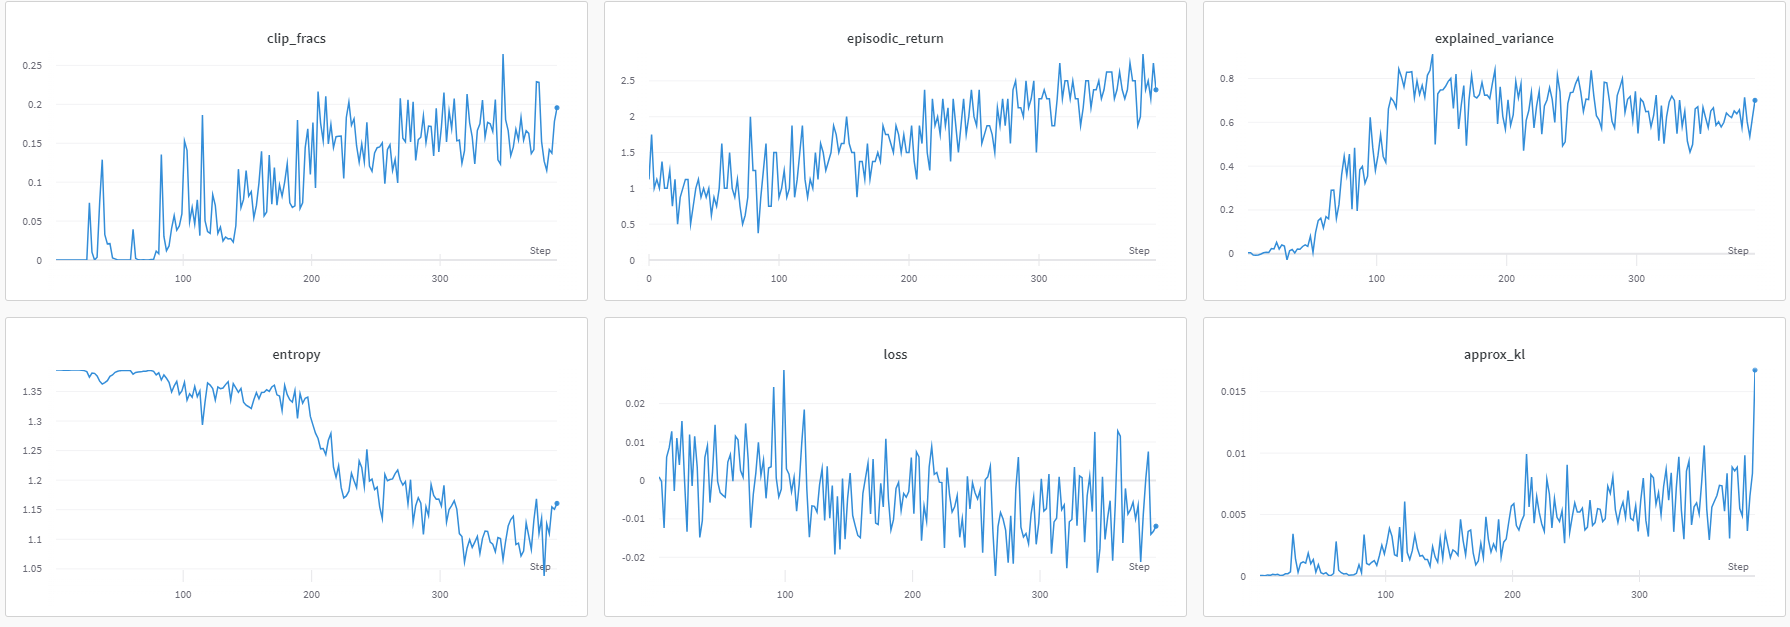


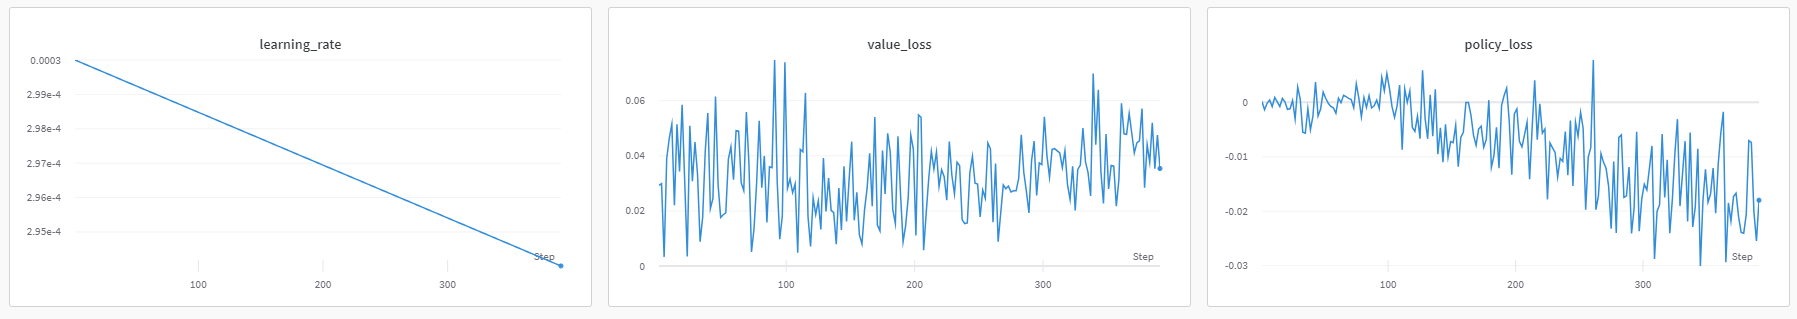